In [1]:
import sys
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from torch.nn import functional as F


################# data function #################################
def DrugSplit(data_idx, drug_type):
    data_test_idx = [item for item in data_idx if item[1]==drug_type]
    data_train_idx = [item for item in data_idx if item[1]!=drug_type]
    return data_train_idx,data_test_idx

def CellSplit(data_idx,cell_type):
    data_test_idx = [item for item in data_idx if item[0]==cell_type]
    data_train_idx = [item for item in data_idx if item[0]!=cell_type]
    return data_train_idx,data_test_idx

def calculate_drug_pcc(all_drug_ids, data_idx, data_Y, all_IC50_pre):
    drug_pcc = []
    drug_loss = []
    drug_scc = []
    for drug in all_drug_ids:
        if_this_drug = []
        for item in data_idx:
            if item[1] == drug:
                if_this_drug.append(True)
            else:
                if_this_drug.append(False)
        IC50_act = data_Y[if_this_drug]
        IC50_pre = all_IC50_pre[if_this_drug]
        loss = F.mse_loss(IC50_act.cpu(), IC50_pre.cpu()).item() # loss
        drug_loss.append(loss)
        pcc, _ = pearsonr(IC50_act.detach().cpu().numpy(), IC50_pre.detach().cpu().numpy())  # pearson
        drug_pcc.append(pcc)
        spear, _ = spearmanr(IC50_act.detach().cpu().numpy(), IC50_pre.detach().cpu().numpy())  # spearman
        drug_scc.append(spear)
    return drug_loss, drug_pcc, drug_scc

def calculate_cancer_pcc(all_cancer_types, data_idx, data_Y, all_IC50_pre):
    cancer_loss = []
    cancer_pcc = []
    cancer_scc = []
    for cancer in all_cancer_types:
        if_this_cancer = []
        for item in data_idx:
            if item[3] == cancer:
                if_this_cancer.append(True)
            else:
                if_this_cancer.append(False)
        IC50_act = data_Y[if_this_cancer]
        IC50_pre = all_IC50_pre[if_this_cancer]
        loss = F.mse_loss(IC50_act.cpu(), IC50_pre.cpu()).item()
        cancer_loss.append(loss)
        pcc, _ = pearsonr(IC50_act.detach().cpu().numpy(), IC50_pre.detach().cpu().numpy())
        cancer_pcc.append(pcc)
        spear, _ = spearmanr(IC50_act.detach().cpu().numpy(), IC50_pre.detach().cpu().numpy())  # spearman
        cancer_scc.append(spear)
    return cancer_loss, cancer_pcc, cancer_scc

def find_highest_pcc_drug(data_idx, drug_pcc, all_drug_ids):  # max 5
    max_position = sorted(range(len(drug_pcc)), key=lambda i: drug_pcc[i], reverse=True)[:5]
    max_pcc = [drug_pcc[i] for i in max_position]
    drug_name = [all_drug_ids[i] for i in max_position]
    highest_index = [item for item in data_idx if item[1] in drug_name]
    return drug_name, highest_index

def find_highest_pcc_cancer(data_idx, cancer_pcc, all_cancer_types):
    max_pcc = max(cancer_pcc)
    max_position = cancer_pcc.index(max_pcc)
    cancer_name = all_cancer_types[max_position]
    highest_index = [item for item in data_idx if item[3]==cancer_name]
    return cancer_name, highest_index

def load_model(model_paths, device, model_name_1, model_name_2):
    all_model_names = ['deepcdr', 'scbert', 'scgpt', 'geneformer', 'scfoundation', 'scmamba']
    if model_name_1 not in all_model_names or model_name_2 not in all_model_names:
        raise ValueError('Model name should be deepcdr, scbert, scgpt, geneformer, scfoundation, scmamba!')
    model_1 = torch.load(model_paths[model_name_1], map_location = device)
    model_2 = torch.load(model_paths[model_name_2], map_location = device)
    return model_1.eval(), model_2.eval()

def predict_pcc(test_data_paths, all_drug_ids, all_cancer_types, device, drug_or_cancer,
                mod_1, mod_2, name_1, name_2):
    all_names = ['deepcdr', 'scbert', 'scgpt', 'geneformer', 'scfoundation', 'scmamba']
    if name_1 not in all_names or name_2 not in all_names:
        raise ValueError('Model name should be deepcdr, scbert, scgpt, geneformer, scfoundation, scmamba!')

    mod1_X, mod1_Y, mod1_idx = torch.load(test_data_paths[name_1],map_location=device)  # 可能报错，pytorch版本不一致，用本地intpreter运行run_deepcdr_pretrain至test_data
    mod1_X_drug_feat, mod1_X_drug_adj, mod1_X_mutation, mod1_X_gexpr, mod1_X_methylation = mod1_X
    mod2_X, mod2_Y, mod2_idx = torch.load(test_data_paths[name_2],map_location=device)
    mod2_X_drug_feat, mod2_X_drug_adj, mod2_X_mutation, mod2_X_gexpr, mod2_X_methylation = mod2_X
    mod1_IC50_pre = mod_1(mod1_X_drug_feat, mod1_X_drug_adj, mod1_X_mutation, mod1_X_gexpr, mod1_X_methylation)
    mod1_IC50_pre = mod1_IC50_pre.squeeze(1)
    mod2_IC50_pre = mod_2(mod2_X_drug_feat, mod2_X_drug_adj, mod2_X_mutation, mod2_X_gexpr, mod2_X_methylation)
    mod2_IC50_pre = mod2_IC50_pre.squeeze(1)
    if drug_or_cancer == 'drug':
        mod1_drug_loss, mod1_drug_pcc, mod1_drug_scc = calculate_drug_pcc(all_drug_ids, mod1_idx, mod1_Y, mod1_IC50_pre)
        mod2_drug_loss, mod2_drug_pcc, mod2_drug_scc = calculate_drug_pcc(all_drug_ids, mod2_idx, mod2_Y, mod2_IC50_pre)
        return mod1_drug_pcc, mod2_drug_pcc
    else:
        mod1_cancer_loss, mod1_cancer_pcc, mod1_cancer_scc = calculate_cancer_pcc(all_cancer_types, mod1_idx,
                                                                                  mod1_Y, mod1_IC50_pre)
        mod2_cancer_loss, mod2_cancer_pcc, mod2_cancer_scc = calculate_cancer_pcc(all_cancer_types, mod2_idx,
                                                                                  mod2_Y, mod2_IC50_pre)
        return mod1_cancer_pcc, mod2_cancer_pcc



################# plot function #################################
def bar_all_plot(results, plot_path, plot_type):
    deepcdrRes, scbertRes, scgptRes, genefRes, scfounRes, scmambaRes = (results['deepcdr'], results['scbert'],
                              results['scgpt'], results['geneformer'], results['scfoundation'], results['scmamba'])
    deepcdrRes['Model'] = 'deepCDR'
    scbertRes['Model'] = 'scBERT'
    scgptRes['Model'] = 'scGPT'
    genefRes['Model'] = 'geneformer'
    scfounRes['Model'] = 'scFoundation'
    scmambaRes['Model'] = 'scMamba'

    df = pd.concat([deepcdrRes, scbertRes, scgptRes, genefRes, scfounRes, scmambaRes])  # concatenate
    melted_df = df.melt(id_vars=['Model'], value_vars=['PCC', 'SRCC'], var_name='Variable', value_name='Value')  # melt
    # plot
    plt.figure(figsize=(5.8, 4.2))
    ax = sns.barplot(data=melted_df, x='Model', y='Value', hue='Variable', errorbar='se',
                     palette=['#de6766', '#f9d2c0'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=10, horizontalalignment='right')
    plt.ylim(0.7, 1)
    for p in ax.patches:  # add number on each bar
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,  # x
            height + 0.005,  # y
            f'{height:.3f}',  # label content
            ha='center',
            va='bottom'
        )
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(f'{plot_path}/1_compare.{plot_type}', bbox_inches='tight')
    plt.show()

def scatter_plot(mod1_pcc, mod2_pcc, mod1_name, mod2_name, plot_path, plot_type, drug_or_cancer, ax=None):
    # plt.figure(figsize=(4, 4))
    sns.scatterplot(x=mod1_pcc, y=mod2_pcc, ax=ax)  # change x, y
    plt.plot([min(mod1_pcc), max(mod1_pcc)], [min(mod1_pcc), max(mod1_pcc)],
             color='red', ax=ax)
    if drug_or_cancer == 'drug':
        plt.title('All Drugs')
    elif drug_or_cancer == 'cancer':
        plt.title('All Cancer Types')
    else:
        raise ValueError('Parameter \'drug_or_cancer\' should be \'drug\' or \'cancer\'')
    plt.xlabel(f"{mod1_name} PCC")
    plt.ylabel(f"{mod2_name} PCC")
    # plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(f'{plot_path}/2_{drug_or_cancer}_scatter_{mod1_name}_{mod2_name}.{plot_type}', bbox_inches='tight')
    plt.show()

def leave_plot(leave_files, plot_path, plot_type, mod1_name, mod2_name):
    column_names = ['loss', 'pcc', 'scc']
    mod1_leave = pd.read_csv(leave_files[mod1_name], names=column_names, index_col=0)
    mod2_leave = pd.read_csv(leave_files[mod2_name], names=column_names, index_col=0)
    inc = mod2_leave['pcc'] - mod1_leave['pcc']
    inc.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=np.arange(inc.shape[0]), y=inc, s=3)  # s=8 设置散点大小
    plt.axhline(0, color='r', linestyle='--')  # 添加一条红色的虚线
    plt.xlabel('Drugs')
    plt.ylabel(f'{mod2_name} PCC higher than {mod1_name}')
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(f'{plot_path}/3_{mod2_name}_{mod1_name}_leave_drug.{plot_type}', bbox_inches='tight')
    plt.show()


In [3]:
import torch

device = torch.device("cuda:2" if torch.cuda.is_available() else 'cpu')
# data saved, same to 
save_path = '/home/share/huadjyin/home/s_qiuping1/hanyuxuan/save'
plot_path = '/home/share/huadjyin/home/s_qiuping1/hanyuxuan/evaluatePlot'  # path to save figs
plot_type = 'pdf'

model_paths = {
    'deepcdr': f'{save_path}/modelSave/no/best_no_model.pt',
    'scbert': f'{save_path}/modelSave/scbert/best_scbert_model.pt',
    'scgpt': f'{save_path}/modelSave/scgpt/best_scgpt_model.pt',
    'geneformer': f'{save_path}/modelSave/geneformer/best_geneformer_model.pt',
    'scfoundation': f'{save_path}/modelSave/scfoundation/best_scfoundation_model.pt',
    'scmamba': f'{save_path}/modelSave/scmamba/best_scmamba_model.pt'
}

test_data_paths = {
    'deepcdr': f'{save_path}/data/test_data/no_test_data.pth',
    'scbert': f'{save_path}/data/test_data/scbert_test_data.pth',
    'scgpt': f'{save_path}/data/test_data/scgpt_test_data.pth',
    'geneformer': f'{save_path}/data/test_data/geneformer_test_data.pth',
    'scfoundation': f'{save_path}/data/test_data/scfoundation_test_data.pth',
    'scmamba': f'{save_path}/data/test_data/scmamba_test_data.pth'
}

mut_feat, drug_feat, gexpr_feat, methy_feat, all_data_idx = torch.load(f'{save_path}/data/meta.pth')
all_drug_ids = list(set(drug_feat.keys()))
all_cancer_types = ["ALL", "BLCA", "BRCA", "DLBC", "LIHC", "LUAD",
                    "ESCA", "GBM", "HNSC", "KIRC", "LAML", "LCML", "LGG",
                    "LUSC", "MESO", "MM", "NB", "OV", "PAAD", "SCLC", "SKCM",
                    "STAD", "THCA", 'COAD/READ']

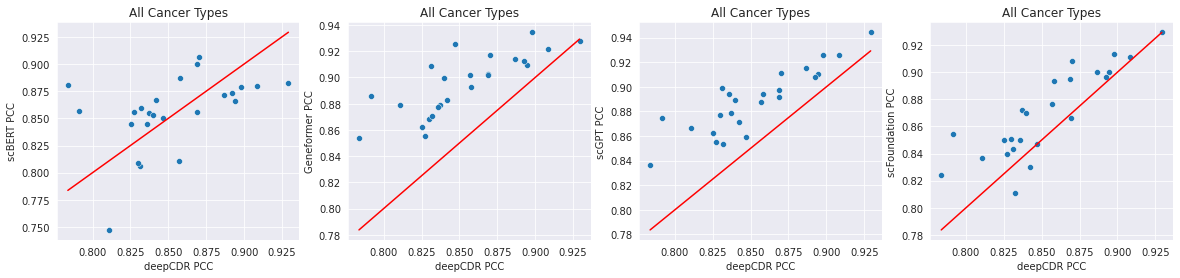

In [4]:
# deepcdr / scgpt / scbert / geneformer / scfoundation / scmamba
# model_name_1, model_name_2 = 'deepcdr', 'scgpt'
# drug_or_cancer = 'cancer'  # drug / cancer(meaning cancer type)
# model_1, model_2 = load_model(model_paths, device, model_name_1, model_name_2)
# mod1_pcc, mod2_pcc = predict_pcc(test_data_paths, all_drug_ids, all_cancer_types, device,
#                                  drug_or_cancer, model_1, model_2, model_name_1, model_name_2)
# scatter_plot(mod1_pcc, mod2_pcc, model_name_1, model_name_2, plot_path, plot_type, drug_or_cancer)

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
n = 0
model_name = {'scbert': 'scBERT', 'deepcdr': 'deepCDR', 'geneformer': 'Geneformer', 'scfoundation': 'scFoundation', 'scgpt': 'scGPT'}
for (model_name_1, model_name_2) in [('deepcdr', 'scbert'), ('deepcdr', 'geneformer'), ('deepcdr', 'scgpt'), ('deepcdr', 'scfoundation')]:
    drug_or_cancer = 'cancer'  # drug / cancer(meaning cancer type)
    model_1, model_2 = load_model(model_paths, device, model_name_1, model_name_2)
    mod1_pcc, mod2_pcc = predict_pcc(test_data_paths, all_drug_ids, all_cancer_types, device,
                                 drug_or_cancer, model_1, model_2, model_name_1, model_name_2)
    ax = axes[n]
    n += 1
    sns.scatterplot(x=mod1_pcc, y=mod2_pcc, ax=ax)
    sns.lineplot(x=[min(mod1_pcc), max(mod1_pcc)], y=[min(mod1_pcc), max(mod1_pcc)],
             color='red', ax=ax)
    ax.set_title('All Cancer Types')
    ax.set_xlabel(f"{model_name[model_name_1]} PCC")
    ax.set_ylabel(f"{model_name[model_name_2]} PCC")

In [ ]:
def scatter_plot(mod1_pcc, mod2_pcc, mod1_name, mod2_name, plot_path, plot_type, drug_or_cancer, ax=None):
    # plt.figure(figsize=(4, 4))
    sns.scatterplot(x=mod1_pcc, y=mod2_pcc, ax=ax)  # change x, y
    plt.plot([min(mod1_pcc), max(mod1_pcc)], [min(mod1_pcc), max(mod1_pcc)],
             color='red', ax=ax)
    if drug_or_cancer == 'drug':
        plt.title('All Drugs')
    elif drug_or_cancer == 'cancer':
        plt.title('All Cancer Types')
    else:
        raise ValueError('Parameter \'drug_or_cancer\' should be \'drug\' or \'cancer\'')
    plt.xlabel(f"{mod1_name} PCC")
    plt.ylabel(f"{mod2_name} PCC")
    # plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(f'{plot_path}/2_{drug_or_cancer}_scatter_{mod1_name}_{mod2_name}.{plot_type}', bbox_inches='tight')
    plt.show()